# Continuous Control

The environment for this project is [Reacher](https://github.com/udacity/deep-reinforcement-learning/tree/master/p2_continuous_control) from Unity, and it's provided in the `setup` folder. We'll implement the A2C algorithm as the synchronous version of [A3C](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) (but the input won't be directly from pixels). We'll also include a variation called Generalized Advantage Estimation, or [GAE](https://arxiv.org/pdf/1506.02438.pdf) for short. Results will be shown in this notebook and the best solution will be implemented in `main.py`.

![final](imgs/gif.gif "final")

> The model used to generate this gif is `final.pth` (A2C-GAE with `n = 8` steps), which was trained for 600 episodes using `main.py`.

## 1. Prepare dependencies and environment

Take a look at README.md before executing this notebook and make sure that the kernel is set to **p2_continuous_control**.

In [1]:
!pip -q install ./setup

import sys
import platform

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch import nn

from setup import unityagents
from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Unity environments contain **brains**, our interfaces for controlling agents. We'll be conrtolling the first (default) brain in the environment. It's also useful to keep information such as `state_size`, `action_size` and `num_agents`.

In [2]:
env = None
system = platform.system()
if system == 'Linux':
    env = UnityEnvironment(file_name="setup/Reacher_Linux/Reacher.x86_64")
elif system == 'Darwin':
    env = UnityEnvironment(file_name="setup/Reacher.app")
elif system == 'Windows':
    env = UnityEnvironment(file_name="setup/Reacher_Windows_x86_64/Reacher.exe")
else:
    print('Cannot find environment for this system.')

# use the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2. Actor

A2C is an **actor-critic method** and as such requires two models, one to represent the policy (the actor) and one to represent the value function (the critic). These models could be represented with just one network that has two distinct final layers – this is particularly useful when there are convolutional layers at the beginning of the network, as it helps extrapolating important information from the environment – but we don't need to do that, since the input consists of only 33 values per agent. We'll instead implement two separate models.

The `Actor` class is straightforward and consists of only fully connected layers:

- `state_size` $\to 64$ followed by `relu` activations
- $64 \to 128$ and `relu`
- $128 \to 64$ and `relu`
- $64 \to \mu$, that is $64 \to$ `action_size`.

Another important aspect of the actor is that it should output a normal distribution, so $\mu$ is not enough. To output $\sigma$ I decided to create a dedicated `nn.Parameter` of size `action_size` that does not depende on the input, although can still be updated by autograd.

In this implementation, **the actor is always used in a batch**. There are 20 independent agents that share the same network, so the input is made of 20 vectors for a total size of `[num_agents, state_size]` and, similarly, the output contains 20 $\mu$ vectors that can be seen as a matrix of size `[num_agents, action_size]`. Note that $\sigma$ does not change with the number of agents, since it will be applied equally to all `torch.distributions` objects.

In [3]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers=[64, 128, 64]):
        super(Actor, self).__init__()
        self.action_size = action_size

        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])

        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the actor will output the parameters of a normal distribution,
        self.mu_layer = nn.Linear(hidden_layers[-1], action_size)
        self.sigma = nn.Parameter(torch.ones(1, action_size))

    def forward(self, state):
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        mu = self.mu_layer(state)
        return mu, self.sigma

## 3. Critic

The `Critic` class is also made of only fully connected layers:

- `state_size` $\to 64$ followed by `relu` activations
- $64 \to 128$ and `relu`
- $128 \to 64$ and `relu`
- $64 \to V(s)$, that is $64 \to 1$ and no activation.

`Critic` is very similar to the `DQN` class, except it does not process the value for state-action pairs $Q(s, a)$, but only the value of the state $V(s)$. The reason for this is that we don't care about the value of an individual state-action pair because we're going to use the critic to calculate **advantages**, and based on that we'll tweak the probability distribution that the actor generates.

As for the actor, **the critic is always used in batches** of 20 independent states, for a total size of `[num_agents, state_size]` and. Similarly, the output contains 20 $V(s)$ values that can be seen as a matrix of size `[num_agents, 1]`.

In [4]:
class Critic(nn.Module):

    def __init__(self, state_size, hidden_layers=[64, 128, 64]):
        super(Critic, self).__init__()

        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])

        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the critic outputs only a scalar V(s)
        self.value_layer = nn.Linear(hidden_layers[-1], 1)

    def forward(self, state):
        # connect layers to each other and put relu activations between them
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        value = self.value_layer(state)
        return value

## 4. Advantage estimation

As mentioned, the critic is used to calculate advantages. An advantage value gives us a way to evaluate an action. For example, given a tuple $(s, a, r, s')$, as an indication for the goodness of the action $a$, we can calculate the advantage $A = r + V(s') - V(s)$, which is hopefully positive, but could also be negative. Since the output of the actor is a probability distribution, we can use **gradient ascent to increase** the log probability $\nabla_\theta \ln \pi_\theta(a | s)$ of that action being taken, and if we change the sign we will **decrease** it instead.

Combining the two ideas in a single expression, we get $\nabla_\theta \ln \pi_\theta(a | s) \cdot A$. This is how we'll decide whether we'll increase or decrease the probability of the action $a$, and by how much. Of course, in order to do that, our estimate of $V$, and consequently of $A$ must be accurate. The following sections describe two ways to obtain these values, based on the fact that A2C works using $n$-step TD estimates.

### 4.1 $n$-step

<p align="center"><img src="imgs/n-step.png" width="500" /></p>

The overline brackets highlights how $V$ is updated and how the advantage is estimated. In fact, when updating $V(s_{i+n-1})$ we consider the standard one-step TD error that only includes $R_{i+n}$ and $V(s_{i+n})$. However, in order to improve our next estimates, we now substitute $V(s_{i+n-1})$ with $R_{i+n} + \gamma V(s_{i+n})$, so that the update to $V(s_{i+n-2})$ will be a two-step TD error. I decided to include $G(s_{i+n+1})$ in the image to highlight that there is only one bootstrapping step in this process. The same reasoning is used to estimate the advantages. For example, if $n=3$ we have
$$
\begin{align}
\begin{split}
V(s_{i+2}) \leftarrow & R_{i+3} + \gamma V(s_{i+3}) \\
V(s_{i+1}) \leftarrow & R_{i+2} + \gamma R_{i+3} + \gamma^2 V(s_{i+3}) \\
V(s_{i}) \leftarrow & R_{i+1} + \gamma R_{i+2} + \gamma^2 R_{i+3} + \gamma^3 V(s_{i+3})
\end{split}
\qquad\qquad
\begin{split}
A(s_{i+3}) = & R_{i+3} + \gamma V(s_{i+3}) - V(s_{i+2}) \\
A(s_{i+2}) = & R_{i+2} + \gamma R_{i+3} + \gamma^2 V(s_{i+3}) - V(s_{i+1}) \\
A(s_{i+1}) = & R_{i+1} + \gamma R_{i+2} + \gamma^2 R_{i+3} + \gamma^3 V(s_{i+3}) - V(s_{i})
\end{split}
\end{align}
$$
When we take into account that the critic is updated according to the mean squared error, both equations become virtually the same thing, as they are both implemented using discounted returns.

The next two functions, `n_step` and `gae`, take more parameters than they need. Technically, both of them need `rewards, dones, future, critic_out, gamma`, with `gae` also requiring another hyperparameter `tau` that will be explained in the next markdown cell. However, `n_step` and `gae` only affect how advantages are calculated, but we're always going to compute `returns` regardless of this choice, since we need it for the critic. For this reason, I decided to also include `returns` as a parameter, so that we only need to calculate it once. The implementation of `n_step` then becomes trivial.

In [5]:
def n_step(rewards, dones, future, returns, critic_out, gamma, tau):
    return returns - critic_out

### 4.2 GAE

<p align="center"><img src="imgs/gae.png" width="500" /></p>

As already mentioned, the way $V$ is updated is identical in both `n_step` and `gae`, so I left the overline brackets in the image to highlight this fact. On the other hand, the green and orange blocks indicate how the $\hat{A}$ values are computed. These values are not the actual advantages $A$ that `gae` estimates, but they help us get there – except for the last block, where $A$ is the same as $\hat{A}$. For instance, if $n = 3$ we have
$$
\begin{align}
\begin{split}
\hat{A}(s_{i+3}) &= R_{i+3} + \gamma V(s_{i+3}) - V(s_{i+2})\\
\hat{A}(s_{i+2}) &= R_{i+2} + \gamma V(s_{i+2}) - V(s_{i+1})\\
\hat{A}(s_{i+1}) &= R_{i+1} + \gamma V(s_{i+1}) - V(s_{i})
\end{split}
\qquad\qquad
\begin{split}
A(s_{i+3}) &= \hat{A}(s_{i+3})\\
A(s_{i+2}) &= \hat{A}(s_{i+2}) + \gamma \lambda A(s_{i+3})\\
A(s_{i+1}) &= \hat{A}(s_{i+1}) + \gamma \lambda A(s_{i+2})\\
\end{split}
\end{align}\\
$$
Essentially, $\hat{A}$ represents a one-step advantage (as indicated by the contents of the green and orange blocks in the image), while $A$ is a mixture of steps (or blocks in the image), controlled by $\lambda$. Indeed, if we expand $A(s_{i+2})$ we can see that it contains a little bit of both blocks
$$
A(s_{i+2}) = R_{i+2} + \gamma V(s_{i+2}) - V(s_{i+1}) + \gamma \lambda (R_{i+3} + \gamma V(s_{i+3}) - V(s_{i+2}))\\= R_{i+2} + \gamma\lambda R_{i+3} + (1 - \lambda)\gamma V(s_{i+2}) + \gamma^2\lambda V(s_{i+3}) - V(s_{i+1})
$$
Additionally, if $\lambda = 0$ the expression simplifies to a one-step TD approach, whereas with $\lambda = 1$ it becomes like a MC approach
$$
\begin{align}
\lambda = 0 \implies \quad & R_{i+2} + \gamma V(s_{i+2}) - V(s_{i+1})\\
\lambda = 1 \implies \quad & R_{i+2} + \gamma R_{i+3} + \gamma^2 V(s_{i+3}) - V(s_{i+1})
\end{align}
$$
More generally, this is called the $\lambda$-return and is often indicated with TD($\lambda$) – although we'll refer to its hyperparameter as `tau`, because `lambda` is a reserved keyword in python.

In [6]:
def gae(rewards, dones, future, returns, critic_out, gamma, tau):
    
    # create a single tensor for rewards, dones and predicted_values.
    # also, dones and predicted_values have n+1 rows: predictied_values adds G or future at the end
    # whereas dones adds a row of zeros at the beginning; this simplifies access to this data in the loop
    rewards = torch.cat([r.unsqueeze(0) for r in rewards], dim=0)
    dones = torch.cat([torch.zeros([1, 20, 1]).to(device)] + [d.unsqueeze(0) for d in dones], dim=0)
    predictied_values = torch.cat((critic_out, future.unsqueeze(0)), dim=0)

    # retrieve n from a tensor's size, instead of passing it as a parameter
    n = list(critic_out.size())[0]

    # compute A_hats and As backwards, and store the As as you go
    A = torch.zeros([20, 1]).to(device)
    advantages = []
    for i in reversed(range(n)):
        A_hat = rewards[i] + gamma * predictied_values[i+1] * (1 - dones[i+1]) - predictied_values[i] * (1 - dones[i])
        A = A_hat + gamma * tau * A
        advantages.insert(0, A.unsqueeze(0))
    return torch.cat(advantages, dim=0)

## 5. Agent

As stated, the learning algorithm guides the actor with gradient ascent on $\nabla_\theta \ln \pi_\theta(a | s) \cdot A$ and the critic with gradient descent on the mean squared error of returns. To implement this, we can use a **temporary buffer** somewhat similar to the one found in DQN or DDPG, except it is reset after every learning step and there is no sampling involved, so the size will always be limited by `n`. Thus, we can avoid building a dedicated class for it and instead make a few python arrays. The ones that we need are `tmp_r` and `tmp_d`, respectively for storing rewards and the done flag. We do not need to store the actual states and actions, as long as we store their values and log probabilities, respectively. To do this, we use `tmp_critic_out` and `tmp_log_prob`. Finally, we'll need `tmp_ns` to store the `n`-th next state, that we'll use for bootstrapping.

There are very few hyperparameters compared to other methods. What we need is:
- `n` determines how many steps to take for one learning step; `1` is similar to other standard TD methods, while higher values make it more like a MC method
- `calc_advantages` can be either `n_step` or `gae`
- `alpha` is the learning rate of both networks
- `gamma` is the discount factor for the returns
- `tau` in `[0, 1]` will be used only if `calc_advantages` is `gae` and determines how to mix the advantages; `0` makes it a standard TD method, while `1` makes it similar to a MC method, except it is still limited by `n`

The agent has three main functions, but only two of them should be called from the outside: 
- `act`, based on a state tensor `state`, choose an action. This also evaluates the state and the log probability of the action, as well as stores some information.
- `store`, receive a complete tuple and adds some data to the temporary buffer. This counts as a step towards the updates of `actor` and `critic`, and in fact calls `learn()` automatically when needed.
- `learn`, takes all the data in the buffer and calculates discounted returns, advantages using `calc_advantages`, and performs the update of the networks.

Additionally, an agent can be `reset()`.

In [7]:
class A2CAgent:
    
    # -- initialization -- #

    def __init__(self, state_size, action_size, calc_advantages, n=4, 
                 alpha=0.0001, gamma=0.95, tau=0.5):
        
        self.state_size, self.action_size = state_size, action_size
        self.alpha, self.gamma, self.tau = alpha, gamma, tau
        self.calc_advantages = calc_advantages
        self.n = n
        self.reset()

    def reset_temporary_buffer(self):
        # some values will be stored in temporary buffers to
        # avoid re-evaluating them and to speed up the execution
        self.tmp_r, self.tmp_ns, self.tmp_d = [], None, []
        self.tmp_log_prob, self.tmp_critic_out = [], []

    def reset(self):        
        self.actor = Actor(self.state_size, self.action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.alpha)
        
        self.critic = Critic(self.state_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha)

        self.reset_temporary_buffer()
        self.i = 0

    # -- initialization -- #
    
    def act(self, state):
        state = torch.FloatTensor(state).to(device)
        
        # evaluate the current state and choose
        #  - its value
        value = self.critic(state)

        #  - an action from its probability distribution
        mu, sigma = self.actor(state)
        dist = torch.distributions.Normal(mu, sigma)
        action = dist.sample().detach()

        # then also evaluate the log probability of choosing that action.
        # this is what we'll use for backpropagation, together with the estimated advantage
        log_prob = dist.log_prob(action)

        # store these values in a temporary buffer so that we don't need to calculate them again.
        # this is like a replay buffer in DQN, but it gets wiped after an update step.
        self.tmp_log_prob.append(log_prob.unsqueeze(0))
        self.tmp_critic_out.append(value.unsqueeze(0))

        # note: clipping the action to [-1, 1] is required by the environment, but in my tests,
        # clipping it before calculating its log probability resulted in poor performance
        return np.clip(np.array(action), -1, 1)
    
    def store(self, s, a, r, ns, d):
        # ignore s and a because they're already handled in act(state)
        self.tmp_r.append(torch.FloatTensor(r).unsqueeze(1).to(device))
        self.tmp_ns = torch.FloatTensor(ns).to(device)
        self.tmp_d.append(torch.FloatTensor(d).unsqueeze(1).to(device))
        
        # every n steps we should perform an update step
        if self.i == self.n - 1:
            self.learn()
        self.i = (self.i + 1) % self.n

    def learn(self):
        # note that this is called automatically by the agent

        # create a single tensor for the values stored in act(), namely tmp_log_prob and tmp_critic_out
        log_prob = torch.cat(self.tmp_log_prob, dim=0)
        critic_out = torch.cat(self.tmp_critic_out, dim=0)

        # calculate discounted rewards backwards, starting from G or future (the bootstrapping step)
        future = self.critic(self.tmp_ns)
        tmp_returns = []
        ret = future
        for reward, done in zip(reversed(self.tmp_r), reversed(self.tmp_d)):
            ret = reward + self.gamma * (1 - done) * ret
            tmp_returns.insert(0, ret.unsqueeze(0))
        returns = torch.cat(tmp_returns, dim=0).to(device)
        
        # use either n_step or gae to estimate the advantages.
        # note that not all of these parameters are guaranteed to be used by the given function.
        advantages = self.calc_advantages(self.tmp_r, self.tmp_d, future, returns, critic_out, self.gamma, self.tau)

        # train the actor by guiding the increase or decrease of log_prob with the advantages.
        # note the negative sign: pytorch executes gradient descent, so we want to invert that to gradient ascent.
        policy_loss = -torch.mean(log_prob * advantages.detach())
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), 5)  # the use of gradient clipping helped in my tests
        self.actor_optimizer.step()

        # train the critic on the mean squared error between its output and the discounted returns
        value_loss = torch.mean((returns.detach() - critic_out) ** 2)
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), 5)  # the use of gradient clipping helped in my tests
        self.critic_optimizer.step()

        # finally empty the temporary buffer
        self.reset_temporary_buffer()

## 6. Training an agent

Creating an agent is straightforward now. We can make three agents, with some combination of `n_step`, `gae`, and `n`, to see how these parameters affect learning.

- `alpha=0.0001`
- `gamma=0.95`
- `tau=0.5`

In [8]:
agents = [('A2Cn4', A2CAgent(state_size, action_size, n_step, n=4)),
          ('A2Cn8', A2CAgent(state_size, action_size, n_step, n=8)),
          ('A2C-GAEn8', A2CAgent(state_size, action_size, gae, n=8))]

What we define now is a function that connects our `agent` and `env`. Recall that we'll be using the default `brain_name` to interact with the environment. The agent is allowed to store observations and, consequently, learn every `n` steps.

In [9]:
def execute_episode(agent, env):
    # prepare the environment
    scores = np.zeros(num_agents)
    env_info = env.reset(train_mode=True)[brain_name]
    
    # get the initial state
    states = env_info.vector_observations
    while True:

        # evaluate the current state
        actions = agent.act(states)

        # execute the chosen action and get the outcome
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # store the experience (also automatically learn, from time to time)
        agent.store(states, actions, rewards, next_states, dones)

        # prepare for the next iteration
        states = next_states
        scores += rewards

        if np.any(dones):
            break
    
    # return the total rewards obtained
    return np.mean(scores)

We can call the function above repeatedly while **monitoring** what happens, so that we'll be able to compare different approaches. The most important indicator is going to be the average score over 100 consecutive episodes (where each episode's score is the average of its 20 independent agents): the environment is considered **solved when the agents scores +30 or more** under this metric. We'll be training each variation 3 times from scratch, for 600 episodes, and we'll average the results. This way, the learning curves will depend less on the randomness of the environment and more on the actual differences of the proposed approaches.

In [10]:
def train(agent, env, episodes=600, repeat=3, consecutive_episodes=100, show_output=True, save_as=None):

    results = [None] * repeat
    for r in range(repeat):
        partial_results = [None] * episodes

        # reset the agent to start learning from scratch
        agent.reset()
        for i in range(episodes):

            # execute all the episodes and store the results
            score = execute_episode(agent, env)
            partial_results[i] = score
            
            if show_output:
                print("\r[{}] Episode: {}, Score: {}".format(r+1, i+1, score), end="")
                sys.stdout.flush()
        if show_output:
            print()

        results[r] = partial_results

        # store the trained model if requested
        if save_as is not None:
            torch.save(agent.actor.state_dict(), '{}/{}_actor.pth'.format(save_as, r+1))
            torch.save(agent.critic.state_dict(), '{}/{}_critic.pth'.format(save_as, r+1))
            np.save('{}/report_{}'.format(save_as, r+1), np.array(partial_results))

    results = np.array(results)
    if save_as is not None:
        np.save('{}/full_report'.format(save_as), np.array(results))
    
    # use convolutions to calculate the mean and standard deviation summarizing the training step
    mean = signal.convolve2d(results, np.ones([repeat, consecutive_episodes]) / (repeat * consecutive_episodes), mode='valid')    
    v = signal.convolve2d(results, np.ones([1, consecutive_episodes]) / consecutive_episodes, mode='valid')
    std_dev = signal.convolve2d(v ** 2 - mean ** 2, np.ones([repeat, 1]) / repeat, mode='valid') ** (1/2)
    return mean.flatten(), std_dev.flatten(), results

In [11]:
training_results = []
for ag in agents:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, save_as='models/{}'.format(name.replace(" ", "_")))
    training_results.append((mean, std_dev, full_report))
env.close()

Agent: A2Cn4
[1] Episode: 600, Score: 39.00949912806973
[2] Episode: 600, Score: 39.3239991210401
[3] Episode: 600, Score: 39.14199912510812
Agent: A2Cn8
[1] Episode: 600, Score: 39.081999126449226
[2] Episode: 600, Score: 37.057999171689154
[3] Episode: 600, Score: 39.247499122750014
Agent: A2C-GAEn8
[1] Episode: 600, Score: 38.7974991328083
[2] Episode: 600, Score: 39.176499124336985
[3] Episode: 600, Score: 38.591499137412754


## 7. Comparing the results

We can use `matplotlib` to plot the mean of the score. All proposed variants manage to reach the goal of +30, in fact they almost get +40 points. However, there are some notable differences between them.

First, we can see that, for this task, the A2C method with `n = 8` is the first one to reach the goal, solving the environment in 314 episodes, followed by the `n = 4` version and then finally by the GAE version with `n = 8`. However, we can't yet say that the best approach is A2C with `n = 8` and in fact, if we look at its stability (the orange shadow), it clearly exhibits a higher variance after 600 episodes compared to the other two variants.

This seems in line with the fact that Monte Carlo approaches usually have a higher variance, and A2C with `n = 8` is closer to MC than A2C with `n = 4`. As for the remaining variant with GAE, although it also has `n = 8`, it does not show such high variance at the end of the learning process. This may be its strenght: instead of being the fastest method, it may allow for a more flexible and easy choice of `n` (which is notably hard in some tasks) while retaining good convergence properties.

A2Cn4: Solved after 346 episodes
A2Cn8: Solved after 314 episodes
A2C-GAEn8: Solved after 370 episodes


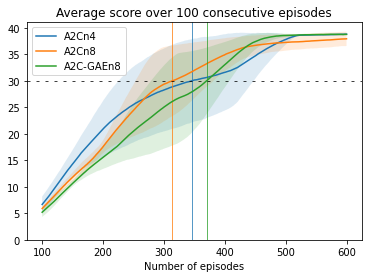

In [13]:
def plot_results(agents, training_results):
    for agent, ts in zip(agents, training_results):
        mean, std_dev, _ = ts
        episode_solved = np.argmax(mean > 30) + 100
        print('{}: Solved after {} episodes'.format(agent[0], episode_solved))

        x = np.arange(100, 100 + mean.size)
        line = plt.plot(x, mean, label = agent[0])
        plt.fill_between(x, mean + std_dev, mean - std_dev, alpha=0.15)
        plt.axvline(episode_solved, lw=0.75, color=line[0].get_color())

    plt.axhline(30, dashes=(4, 8), lw=0.75, color='black')
    plt.xticks(np.arange(1, 1 + mean.size / 100) * 100)
    plt.yticks(np.arange(0, 9) * 5)
    plt.xlabel('Number of episodes')
    plt.title('Average score over 100 consecutive episodes')
    plt.legend()
    plt.show()

plot_results(agents, training_results)

## 8. Possible improvements

One of the things that is usually applied to policy gradient methods is an **entropy** term to help with exploration. In fact, given that the actor outputs probabilities, it is straightforward to add an entropy term to its loss so that it will be maximized. In particular, since we're using a normal distribution here, the ouptut of the model only consists of its parameters, $\mu$ and $\sigma$, and maximizing the entropy is essentially the same as maximizing $\sigma$, or in other words, the randomness of the agent. The entropy term should always be limited by an hyperparameters, otherwise the actor won't be able to converge to any policy.

It would be interesting to compare this solution to other policy gradient algorithms like [REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf), [PPO](https://arxiv.org/pdf/1707.06347.pdf) or [DDPG](https://arxiv.org/pdf/1509.02971.pdf), or even to black-box optimization techniques like [ES](https://arxiv.org/pdf/1703.03864.pdf).

## 9. Conclusions

For this task, the agents proposed manage to play well every time. The models used to create the graphs in section 7 are available in the repository. The full documented code is also available and `main.py` can be executed to train or load a pre-trained A2C-GAE agent with `n = 8` and see it in action, just like it was done to get the model `final.pht`.